In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas_datareader as web
from mpl_toolkits import mplot3d
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize']=(10, 8)
plt.rc('axes', labelsize = 15)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

In [2]:
root = os.getcwd()
PROJECT_ROOT = os.path.join(root, 'Figures')
os.makedirs(PROJECT_ROOT, exist_ok=True)
def save_fig(fig_id, tight_layout = True, fig_extention = 'pdf', resolution=300):
    path = os.path.join(PROJECT_ROOT, fig_id + '.' + fig_extention)
    print('Saving figure', fig_id, '\n\n')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format = fig_extention, dpi =resolution)

In [4]:
SP = web.DataReader('^GSPC', 'yahoo', start='2017-01-01')['Adj Close']
DJI = web.DataReader('^DJI', 'yahoo', start='2017-01-01')['Adj Close']

In [85]:
SP.shape, DJI.shape

((1254,), (1254,))

In [5]:
lretSP= SP.pct_change().apply(lambda x: np.log(1 + x)).dropna()
lretDJI = DJI.pct_change().apply(lambda x: np.log(1 + x)).dropna()

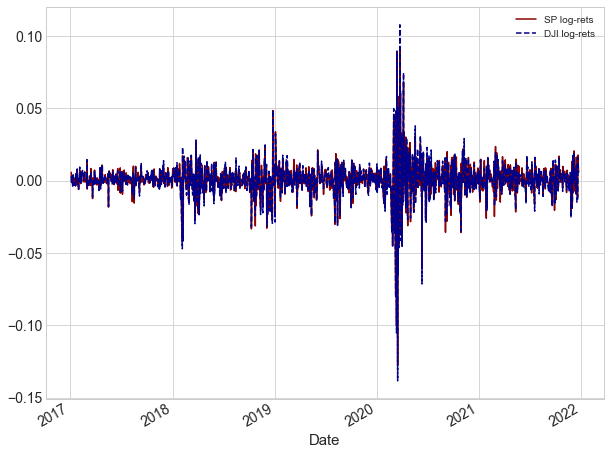

In [6]:
lretSP.plot(label='SP log-rets', color='darkred')
lretDJI.plot(label='DJI log-rets', color='darkblue', linestyle="dashed")
plt.legend()

In [7]:
Data = pd.DataFrame({'SP':lretSP, 'DJI':lretDJI})


In [134]:
Data.describe()

,SP,DJI
count,1253.000000,1253.000000
mean,0.000589,0.000473
std,0.012202,0.012780
min,-0.127652,-0.138418
25%,-0.002972,-0.003308
50%,0.000927,0.000869
75%,0.005706,0.005507
max,0.089683,0.107643


In [93]:
Sk = stats.skew
K = stats.kurtosis

In [136]:
Data.apply(lambda x: Sk(x))

SP    -1.144512
DJI   -1.180496
dtype: float64

In [135]:
Data.apply(lambda x: K(x))

SP     21.871796
DJI    25.033372
dtype: float64

In [137]:
Data.apply(lambda x: K(x)-3)

SP     18.871796
DJI    22.033372
dtype: float64

In [97]:
res = Data.apply(lambda x: stats.shapiro(x))
res.index = ['Statistic', 'p-value']
res

,SP,DJI
Statistic,7.918049e-01,7.739556e-01
p-value,2.872322e-37,2.033515e-38


In [34]:
stats.t.fit(lretTSLA)

(2.84968460893617, 0.002103508102183217, 0.023201173238471852)

In [32]:
def plotKDE(data, theoritical_dist, title):
    data.plot(kind='kde', color='darkblue', label='Empirical density of log-returns')
    plt.yticks(plt.yticks()[0],[str(x)+'%' for x in plt.yticks()[0]])
    x = np.linspace(data.min(), data.max(), len(data))
    dist1 = theoritical_dist[0]; dist2 = theoritical_dist[1]
    DIST1 = getattr(stats, dist1)
    DIST2 = getattr(stats, dist2)

    PARAMS1 = DIST1.fit(data)
    PARAMS2 = DIST2.fit(data)
    
    plt.plot(x, DIST1.pdf(x, *PARAMS1), color='darkred', label = dist1 + ' density')
    plt.plot(x, DIST2.pdf(x, *PARAMS2), color='black', linestyle = 'dashed', label = dist2 + ' Density')
    
    plt.legend()
    plt.title(title + ' empirical density', fontdict={'weight':'bold', 'size': 20})
    return None

In [163]:
from PyCopula import *

Saving figure SP KDE 




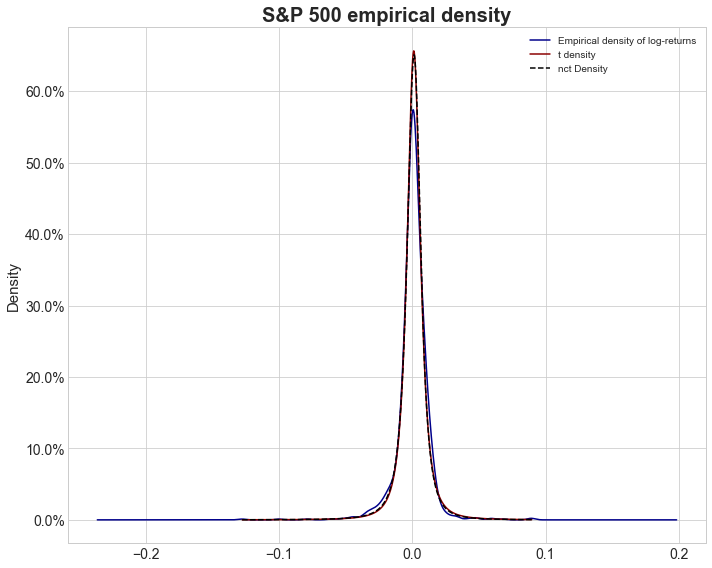

In [36]:
plotKDE(lretSP, ('t', 'nct'), 'S&P 500')
save_fig('SP KDE')

In [119]:
import seaborn as sns

In [28]:
sns.set(rc={'figure.figsize':(11,8.27)})
sns.set(style="whitegrid", color_codes=True)

In [49]:
def rho(x, y):
    return stats.pearsonr(x, y)[0]

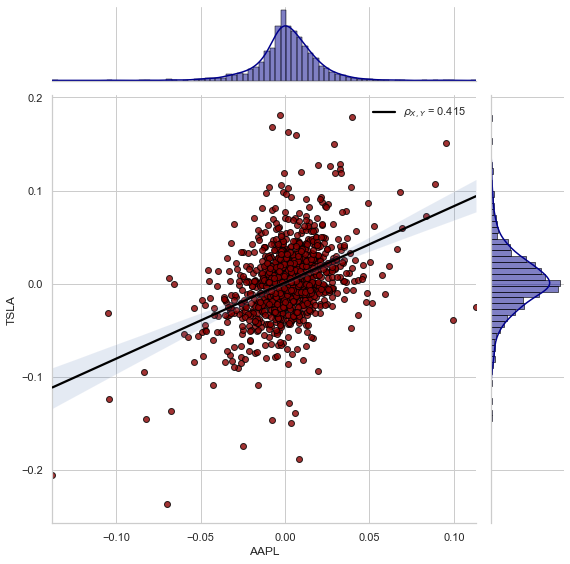

In [82]:
g = sns.jointplot(data = Data, x='AAPL', y='TSLA', kind="reg",
scatter_kws={'color':'darkred', 'edgecolor':'black'},
marginal_kws={'color':'darkblue', 'edgecolor':'black'},
height = 8
)
regline = g.ax_joint.get_lines()[0]
regline.set_color('black')
regline.set_zorder(5)
r, p = stats.pearsonr(lretAAPL, lretTSLA)
g.ax_joint.legend([r'$\rho_{X,Y}$ = %.3f' %r])

In [64]:
from PyCopula import *



Saving figure joint 




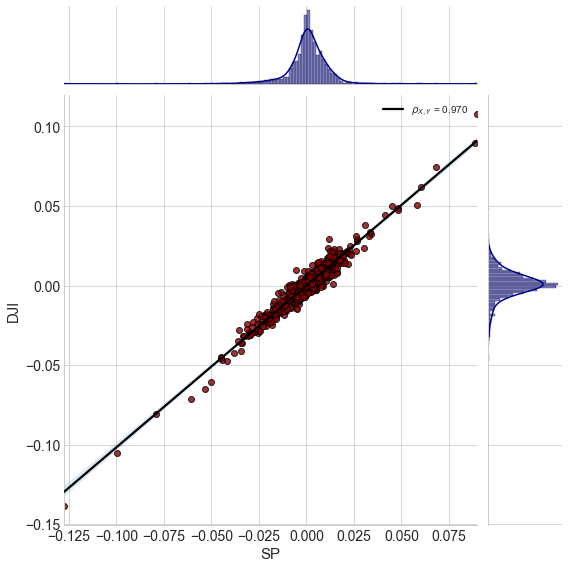

In [66]:
plotJoint(Data, 'SP', 'DJI')
save_fig('joint')

In [60]:
DIST_NAMES = ['t', 'nct']

def dist_fit(data, alpha = 0.05):
    def AIC(data, k, dist, params):
        DIST=getattr(stats, dist)
        logLik = np.sum(DIST.logpdf(data, *params))
        return 2*k - 2*logLik
    results={}
    for dist in DIST_NAMES:
        DIST = getattr(stats, dist)
        PARAMS = DIST.fit(data)
        TEST_PVAL = stats.kstest(data, dist, args=PARAMS)[1]
        TEST_STAT = stats.kstest(data, dist, args=PARAMS)[0]
        if(TEST_PVAL >= alpha):
            aic=AIC(data, k=len(PARAMS), dist=dist, params=PARAMS)
            TUP = PARAMS + (TEST_PVAL,TEST_STAT, aic)
            results[dist]=TUP

    print('(PARAMS, p-value, AIC)')
    return results

Saving figure QQplot 




<ipython-input-2-045fe991ed84>:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


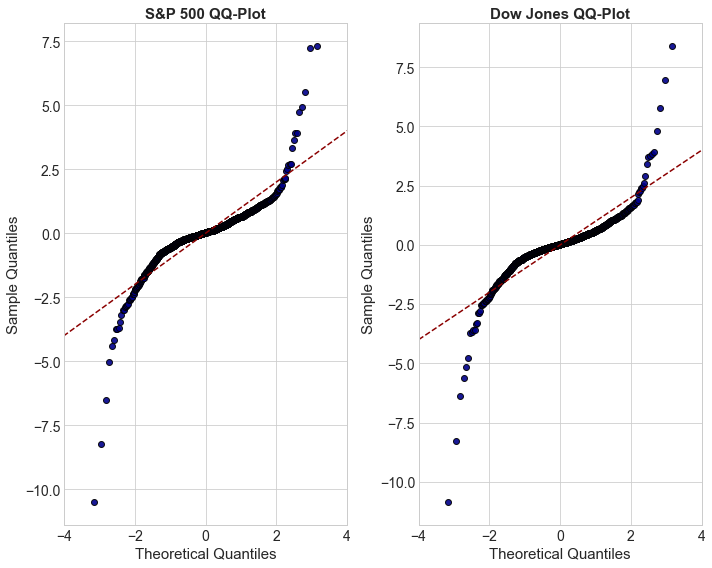

In [56]:
import statsmodels.api as sm
fig, axs = plt.subplots(1,2, constrained_layout=True, sharex=True)
pp1 = sm.ProbPlot(lretSP, fit = True)
qq1 = pp1.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9, ax=axs[0])
sm.qqline(qq1.axes[0], line='45', color='darkred', linestyle='dashed');

pp2 = sm.ProbPlot(lretDJI, fit = True)
qq2 = pp2.qqplot(marker='o', markerfacecolor='darkblue', markeredgecolor='k', alpha=0.9, ax=axs[1])
sm.qqline(qq2.axes[1], line='45', color='darkred', linestyle='dashed')
plt.xlim((-4,4))
axs[0].set_title('S&P 500 QQ-Plot', fontdict={'weight':'bold', 'size':15})
axs[1].set_title('Dow Jones QQ-Plot', fontdict={'weight':'bold', 'size':15})
save_fig('QQplot')

In [61]:
dist_fit(lretSP)

(PARAMS, p-value, AIC)


{'t': (2.06751434487789,
  0.001141939821913387,
  0.00540619370709325,
  0.12065578557296819,
  0.033338556755704185,
  -8209.628137127802),
 'nct': (2.113075378200998,
  -0.1239813515383612,
  0.0018862525833061926,
  0.0054594919563724295,
  0.13559990910733855,
  0.032634788389973246,
  -8209.696645810884)}

In [62]:
dist_fit(lretDJI)

(PARAMS, p-value, AIC)


{'t': (1.992192439048377,
  0.0010204758106240113,
  0.005396483764049316,
  0.7018507711593089,
  0.019803035852475337,
  -8162.309900751448),
 'nct': (2.01948818056385,
  -0.12170733276466435,
  0.0017452910501124783,
  0.0054273969488250785,
  0.7749337141039725,
  0.01853983873133569,
  -8162.442917378253)}

In [12]:
from statsmodels.distributions.empirical_distribution import ECDF

In [26]:
F = ECDF(lretTSLA)
G = ECDF(lretAAPL)

In [24]:
N = lretTSLA.shape[0]

In [20]:
RanksTsla = (N * F(lretTSLA) - 1) / (N - 1)

In [24]:
RanksAAPL = (N * G(lretAAPL) - 1) / (N - 1)

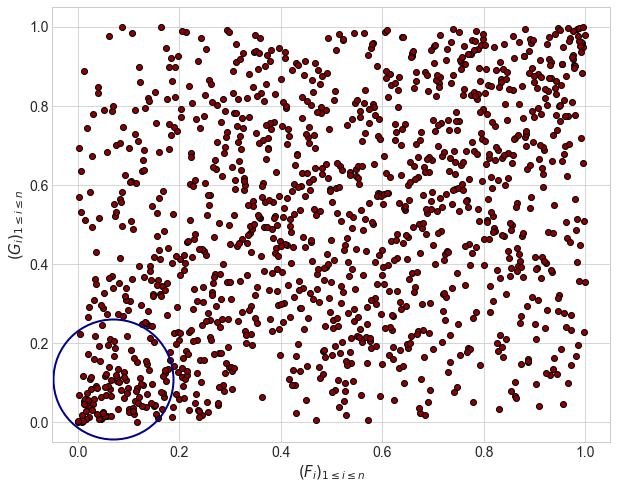

In [63]:
plt.scatter(RanksTsla, RanksAAPL, facecolor='darkred', edgecolors='black')
plt.xlabel(r'$(F_i)_{1\leq i\leq n}$', fontdict={'weight':'bold'})
plt.ylabel(r'$(G_i)_{1\leq i\leq n}$', fontdict={'weight':'bold'})
circle_rad = 60  # This is the radius, in points
plt.plot(0.07, 0.11, 'o',
        ms=circle_rad * 2, mec='darkblue', mfc='none', mew=2)
# plt.annotate('Dépendance forte entre les valeurs extrêmes de la queue gauche (perte)', xy=(0.17, 0.2), xytext=(60, 60),
#             textcoords='offset points',
#             color='darkblue', size='large',
#             arrowprops=dict(
#                 arrowstyle='simple, tail_width=0.1, head_width=0.8,head_length=1.0',
#                 facecolor='k', shrinkB=circle_rad * 1.9)
# )

In [5]:
from PyCopula import *

In [110]:


#chi = VineCopula.BiCopChiPlot(X, Y, PLOT=False)
from rpy2.robjects.packages import importr, data
import rpy2.robjects as ro
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects.numpy2ri as rpyn
VineCopula= importr('VineCopula')
MASS = importr('MASS')
base = importr('base')
ro.r(""" getChi <- function(xhi) {retour = data.frame(lambda = xhi$lambda, chi = xhi$chi)
return(retour)}""")
getChi = ro.globalenv['getChi']


In [32]:
def JointECDF(X, Y, x, y):
    if X.shape[0] != Y.shape[0]:
        print('Please enter equal size vectors, returning 0 ...')
        return 0.
    
    
    N = X.shape[0]
    values = np.array([sum((X <= i) & (Y <= j)) / N for i, j in zip(x, y)])
    return values


In [33]:
x = [0.01, 0.02]; y = [-0.006, 0.02]
JointECDF(lretTSLA, lretAAPL, x, y)


array([0.20367412, 0.69648562])

In [111]:
F_i = (N * F(lretTSLA) - 1) / (N - 1)
G_i = (N * G(lretAAPL) - 1) / (N - 1)
H_i = (N * JointECDF(lretAAPL, lretTSLA, lretAAPL, lretTSLA) - 1) / (N - 1)

In [75]:
def sgn(X):
    return np.array([(x >= 0) * 1 - 1 * (x < 0) for x in X])

In [76]:
sgn([-1, 2])

array([-1,  1])

In [79]:
xhi = (H_i - F_i * G_i) / np.sqrt(F_i * (1 - F_i) * G_i * (1 - G_i))
lamb = 4 * sgn((F_i - 0.5) * (G_i - 0.5)) * np.maximum((F_i - 0.5)**2, (G_i - 0.5)**2)

<ipython-input-79-0d4d1811f36d>:1: RuntimeWarning: divide by zero encountered in true_divide
  xhi = (H_i - F_i * G_i) / np.sqrt(F_i * (1 - F_i) * G_i * (1 - G_i))
<ipython-input-79-0d4d1811f36d>:1: RuntimeWarning: invalid value encountered in true_divide
  xhi = (H_i - F_i * G_i) / np.sqrt(F_i * (1 - F_i) * G_i * (1 - G_i))


Text(0, 0.5, '$\\chi$')

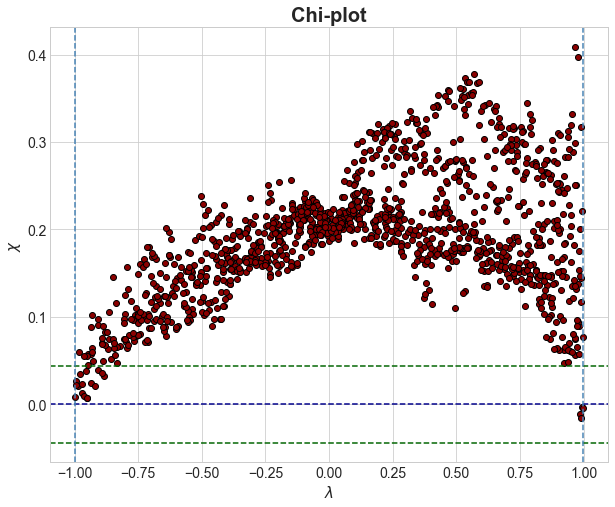

In [95]:
plt.scatter(lamb, xhi, facecolors='darkred', edgecolors='black')
plt.axhline(y = 0., linestyle="dashed", color='darkblue')
plt.axhline(y = 1.54 / np.sqrt(N), linestyle="dashed", color='darkgreen')
plt.axhline(y = -1.54 / np.sqrt(N), linestyle="dashed", color='darkgreen')
plt.axvline(-4 * (1 / (N - 1) - 0.5 )**2, linestyle="dashed", color='steelblue')
plt.axvline(4 * (1 / (N - 1) - 0.5 )**2, linestyle='dashed', color='steelblue')
plt.title('Chi-plot', fontdict={'weight':'bold', 'size':20})
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\chi$')


In [5]:
from PyCopula import *

Saving figure ChiPlot 




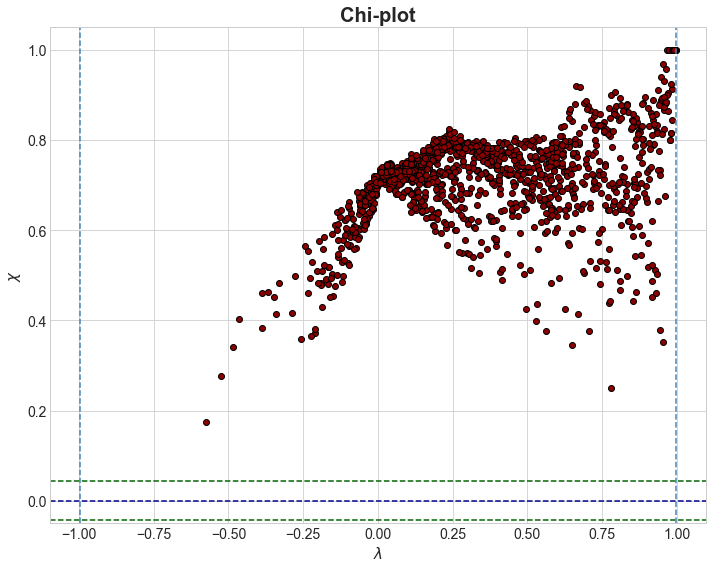

In [92]:
ChiPlot(lretSP, lretDJI)
save_fig('ChiPlot')

In [9]:
import scipy.integrate as integrate

In [97]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def pdf_kde_mv(new_data, data, data_type):
    data_kde = KDEMultivariate(data, var_type=data_type)
    return data_kde.pdf(new_data)

In [100]:
evaluation_points = np.stack([x, y], axis=1)


In [102]:
pdf_kde_mv(evaluation_points, Data.values, "cc")

array([3.72470525e+003, 8.68608878e+000, 9.72450003e-001, 3.79425833e-021,
       2.61200456e-127, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [119]:
kd.iloc[:, 2:]

,z.1,z.2,z.3,z.4,z.5,z.6,z.7,z.8,z.9,z.10,...,z.16,z.17,z.18,z.19,z.20,z.21,z.22,z.23,z.24,z.25
1,4.602787e+01,3.313348e-07,1.235963e-31,6.995861e-61,3.624227e-65,9.729308e-86,1.353446e-122,9.756453e-176,2.819638e-235,1.382146e-282,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1.283668e-05,9.240573e-14,3.698226e-38,2.511886e-27,1.301290e-31,3.493339e-52,4.859589e-89,2.195819e-140,2.043998e-171,1.001939e-218,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2.784506e-25,2.004446e-33,7.016822e-19,7.014914e-07,3.634097e-11,9.755804e-32,1.357132e-68,1.218325e-89,1.152474e-120,5.649265e-168,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,4.697938e-58,7.900179e-40,1.524146e-11,1.523731e+01,7.893736e-04,2.119089e-24,2.926857e-37,5.342905e-52,5.054122e-83,2.477458e-130,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,3.585002e-90,1.334709e-45,2.574994e-17,2.574294e-05,1.333621e-09,2.833975e-14,9.983426e-13,1.822450e-27,1.723947e-58,8.450540e-106,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,4.710887e-109,1.753880e-64,3.383682e-36,3.382762e-24,1.105978e-20,7.518613e-03,2.648630e-01,4.835009e-16,4.573679e-47,3.887274e-86,...,1.757490e-319,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,4.814816e-141,1.792573e-96,3.458331e-68,5.197004e-56,2.282190e-22,1.551469e-04,5.465460e-03,1.730422e-13,2.685774e-29,9.849990e-58,...,1.496089e-258,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,3.827545e-186,1.425009e-141,2.749205e-113,2.792041e-71,3.662864e-37,6.809657e-19,2.496892e-02,7.479110e-02,1.169443e-14,5.435878e-28,...,5.571250e-208,4.899817e-265,2.855699e-321,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2.366599e-244,8.810932e-200,1.376727e-149,3.486020e-99,1.301856e-53,1.452206e-20,8.394336e-04,1.450291e+01,2.385730e-02,7.015673e-07,...,1.285729e-157,4.331366e-200,9.639115e-251,1.661080e-300,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
10,1.138132e-315,2.736087e-257,3.806790e-183,1.581393e-117,3.404184e-68,3.797341e-35,7.426259e-14,5.157168e-03,1.627006e-01,9.323633e+01,...,2.588325e-108,2.979659e-148,3.709764e-185,6.392944e-235,5.708840e-301,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [128]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv
z_data = kd.iloc[:, 2:]
z = z_data.values
sh_0, sh_1 = z.shape
x, y = kd['x'], kd['y']
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='EPDF', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()
save_fig('fig')

Saving figure fig 




<Figure size 720x576 with 0 Axes>

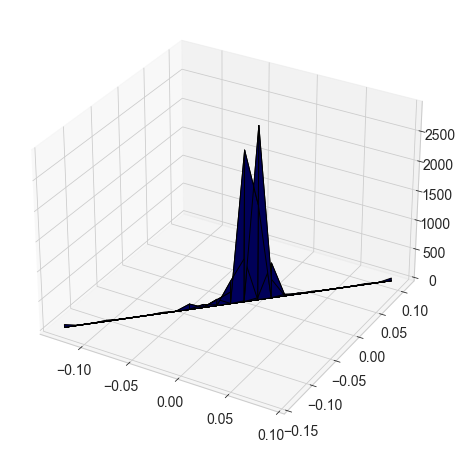

In [127]:
ax = plt.axes(projection='3d')

z_data = kd.iloc[:, 2:]
z = z_data.values
sh_0, sh_1 = z.shape
x, y = kd['x'], kd['y']
ax.plot_surface(x, y, z, rstride=1, cstride=1, color='darkblue', edgecolor='black')

In [14]:
integrate.quad(f, 0, 1)

(0.5, 5.551115123125783e-15)

In [17]:
from scipy.special import binom

In [19]:
# C_n^k = binom(n, k)
binom(3, 1)

3.0

In [105]:
def integrand(w, i, N):
    K = w * (1 - np.log(w))
    k = - np.log(w)
    return  N * binom(N - 1, i - 1) * w * k * (K ** (i - 1)) * ((1 - K) ** (N - i))



In [106]:
H_i = (N * JointECDF(lretAAPL, lretTSLA, lretAAPL, lretTSLA) - 1) / (N - 1)

In [107]:
W = np.array([ integrate.quad(lambda w : integrand(w, i , N), 0, 1)[0] for i in np.arange(1, N + 1)])

In [124]:
H_i.sort()


In [121]:
def k(w):
    return w * (1 - np.log(w))

In [144]:
from scipy import interp1d
f = interp1d(W, H_i)

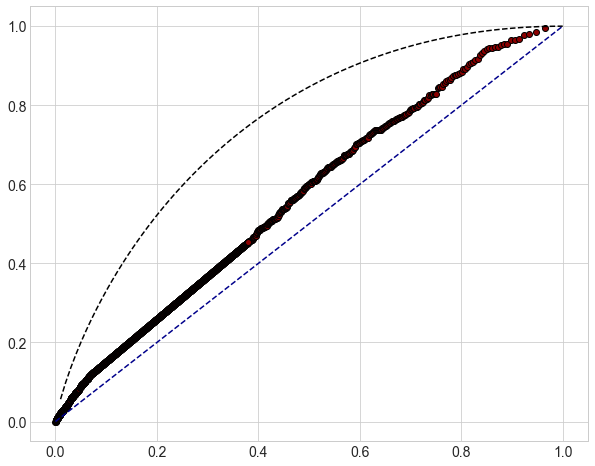

In [169]:
plt.scatter(W, H_i, facecolor='darkred', edgecolors='black')
plt.plot(np.linspace(0, 1, 100), k(np.linspace(0, 1, 100)), linestyle='dashed', color='black')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='darkblue', linestyle='dashed')
plt.scatter(np.linspace(0.07, 0.38, 1000), f(np.linspace(0.07, 0.38, 1000)),  facecolor='darkred', edgecolors='black')


In [170]:
tup = (1, 2)
tup[0]

1

In [65]:
sum((H_i >=0.2) & (H_i <= 0.4))

358

In [67]:
sim = VineCopula.BiCopSim(2000, 2, par=-0.7, par2 = 4)

In [76]:
d = pd.DataFrame(outs_for)
d.columns = ['X_1', 'X_2']

In [113]:
R = FloatVector(F_i)
S = FloatVector(G_i)

In [95]:
chi = VineCopula.BiCopKPlot(pX, pY, PLOT=False)

In [96]:
ro.r(""" getChi <- function(xhi) {retour = data.frame(W = xhi$W.in, H = xhi$Hi.sort)
return(retour)}""")
getChi = ro.globalenv['getChi']

In [97]:
x = getChi(chi)

In [98]:
with localconverter(ro.default_converter + pandas2ri.converter):
  outs_for = ro.conversion.rpy2py(x)

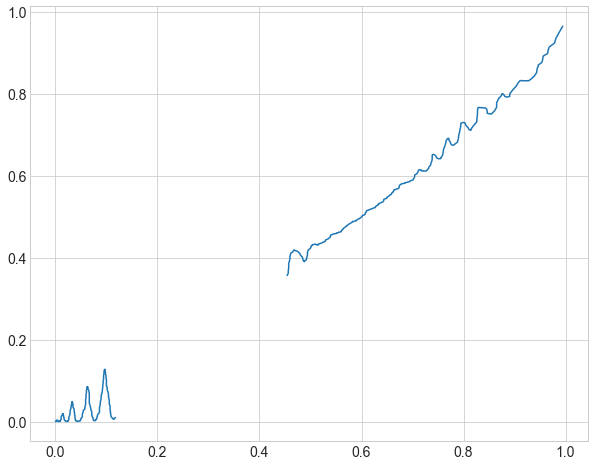

In [100]:
plt.plot(outs_for['H'], outs_for['W'])

In [14]:
from PyCopula import *


In [83]:
Kplot

<function PyCopula.Kplot(X, Y, interp=False, interval=None, nobs=None)>

Saving figure Kplot 




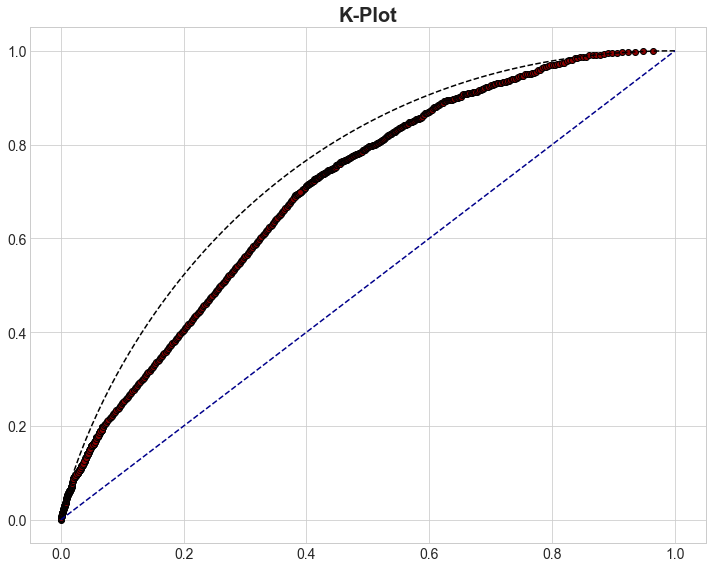

In [90]:
Kplot(lretSP, lretDJI, interp=True, interval = (0.02, 0.39), nobs=200)
plt.title('K-Plot', fontdict={'weight':'bold', 'size':20})
save_fig('Kplot')

Saving figure rankrank 




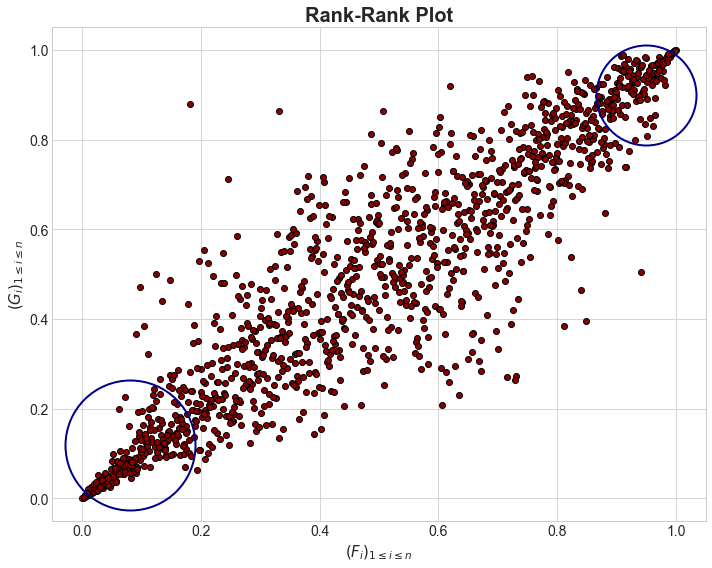

In [78]:
RankRankPlot(lretSP, lretDJI)
circle_rad1 = 65  
circle_rad2 = 50 

plt.plot(0.95, 0.9, 'o',
        ms=circle_rad2 * 2, mec='darkblue', mfc='none', mew=2)
plt.plot(0.08, 0.12, 'o',
        ms=circle_rad1 * 2, mec='darkblue', mfc='none', mew=2)
plt.title('Rank-Rank Plot', fontdict={'weight':'bold', 'size':20})
save_fig('rankrank')

In [21]:
EPDF = stats.gaussian_kde(np.vstack([lretAAPL.values, lretTSLA.values]))

In [26]:
EPDF.pdf()

array([1.12886207])

In [36]:
import statsmodels.api as sm


In [38]:
dens_u = sm.nonparametric.KDEMultivariate(data= [lretAAPL.values, lretTSLA.values],
   var_type='cc', bw='normal_reference')

In [40]:
dens_u.pdf()

array([ 98.55335209, 401.50512171, 292.79622112, ..., 119.27567911,
        81.45287205,  28.30341758])

TypeError: pdf() missing 1 required positional argument: 'x'

In [20]:
from statsmodels.nonparametric.kernel_density import KDEMultivariate

def pdf_kde_mv(new_data, data, data_type):
    data_kde = KDEMultivariate(data, var_type=data_type)
    return data_kde.pdf(new_data)

import numpy as np

def ecdf_mv(new_data, data):
    rows = np.expand_dims(new_data, axis=1)
    ecdf = (data < rows).all(axis=2).mean(axis=1)
    return np.asarray(ecdf)

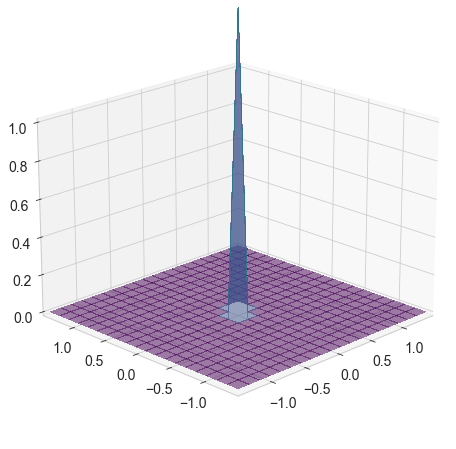

In [23]:
import numpy as np
import matplotlib.pyplot as plt

sample_size = 10_000
bins_count= 20

#sample = np.random.multivariate_normal([0, 0], [[1, 0.0], [0.0, 1]] , sample_size)
bins_edges = np.linspace(-1.5, 1.5, bins_count + 1)

bins_centers = (bins_edges[:-1] + bins_edges[1:]) / 2
X, Y = np.meshgrid(bins_centers, bins_centers)
x, y = X.ravel(), Y.ravel()

evaluation_points = np.stack([x, y], axis=1)

cummulative_probability = pdf_kde_mv(evaluation_points, Data.values, "cc")
# Alternatively:
# cummulative_probability = ecdf_mv(evaluation_points, sample)
cummulative_probability = cummulative_probability.reshape(bins_count, bins_count)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=20., azim=-135)
ax.plot_surface(X, Y, cummulative_probability, rcount=bins_count, ccount=bins_count, 
                antialiased=False, vmin=0, vmax=cummulative_probability.max(), 
                alpha=0.5, cmap='viridis')
ax.margins(0)
ax.set_zlim(0, 1)
plt.show()

In [68]:
sample = np.random.multivariate_normal([0, 0], [[1, 0.0], [0.0, 1]] , sample_size)


In [112]:
X_1 = FloatVector(lretSP.values)
X_2 = FloatVector(lretDJI.values)
KD = MASS.kde2d(X_1, X_2)

In [114]:
ro.r(""" getvals <- function(kde) {retour = data.frame(x = kde$x, y= kde$y, z = kde$z)
return(retour)}""")
getvals = ro.globalenv['getvals']
KD = getvals(KD)

In [170]:
ro.r(""" fit <- function(x, y) {fitting = BiCopSelect(pobs(x), pobs(y) , familyset = c(4), indeptest = F, level = 0.05)
return(fitting)}""")
fitGumbel = ro.globalenv['fit']
x = fitGumbel(X_1, X_2)

In [173]:
from copulae import GumbelCopula

g_cop = GumbelCopula(dim = 2)  # initializing the copula
g_cop.fit(Data)

                SP          DJI
count  1253.000000  1253.000000
mean      0.500000     0.500000
std       0.288560     0.288560
min       0.000797     0.000797
25%       0.250399     0.250399
50%       0.500000     0.500000
75%       0.749601     0.749601
max       0.999203     0.999203


In [186]:
t = g_cop._theta
2 - 2**(1 /t)

0.8209114940603219

In [191]:
2 * (np.log(Data.shape[0]) - g_cop.log_lik(Data))

-2551.161592533849

In [192]:
# 3 : Clayton; 4 : Gumbel; 5 : Frank
X_1 = FloatVector(lretSP.values)
X_2 = FloatVector(lretDJI.values)
pX = VineCopula.pobs(X_1)
pY = VineCopula.pobs(X_2)
set = FloatVector(np.array([4]))
fit = VineCopula.BiCopSelect(pX, pY, familyset = 5, indeptest = False, level = 0.05)
base.summary(fit);

Family
------ 
No:    5
Name:  Frank

Parameter(s)
------------
par:  14.76

Dependence measures
-------------------
Kendall's tau:    0.76 (empirical = 0.77, p value < 0.01)
Upper TD:         0 
Lower TD:         0 

Fit statistics
--------------
logLik:  1144.93 
AIC:    -2287.86 
BIC:    -2282.73 



In [206]:
def Clayton(u, v, theta):
    return np.array([(s**(-theta) + t**(-theta) - 1) ** (-1 / theta) for s, t in zip(u, v)])

def Gumbel(u, v, theta):
    return np.array([np.exp(- ( (-np.log(s))**theta + (-np.log(t))**theta) ** (1 / theta)) for s, t in zip(u, v)])

def Frank(u, v, theta):
    return np.array([(-1 / theta) * np.log(1 + ((np.exp(-theta * s) - 1) * (np.exp(-theta * t) - 1)) / (np.exp(-theta) - 1)) for s, t in zip(u, v)])

In [203]:
def Deheuvels(x, y, u, v):
    F = ECDF(x); G = ECDF(y)
    F_i = F(x); G_i = G(y);
    N = x.shape[0]
    values = np.array([sum((F_i <= i ) & ( G_i <= j)) / N for i, j in zip(u, v)])
    return values



In [215]:
N = lretDJI.shape[0]
F = ECDF(lretSP); G = ECDF(lretDJI)
F_i = N * F(lretSP) / (N + 1); G_i = N * G(lretDJI) / (N + 1)
# Cramér-Von-Mises:
((Deheuvels(lretDJI, lretSP, F_i, G_i) - Frank(F_i, G_i, 14.76))**2).sum()

0.19372197619627934

In [214]:
# Kolmogorov Smirnov:
np.abs(Deheuvels(lretDJI, lretSP, F_i, G_i) - Frank(F_i, G_i, 14.76)).max()

0.02957874328312838

In [255]:
def payoff(omega, price, K):
    return np.maximum((omega * price).sum() - K, 0.)

In [286]:
N = 1000 # number of sim
S_0 = 1000.
K = 1000.
price = 0
days = 1252.
r = 0.025
omega = np.array([0.2, 0.8])

for i in range(N):
    sim = VineCopula.BiCopSim(days, 4, par = 4.21)
    with localconverter(ro.default_converter + pandas2ri.converter):
        Sim= ro.conversion.rpy2py(sim)
    Sim = pd.DataFrame(Sim)
    Sim.columns = ['X', 'Y']
    SimSP =  stats.nct.ppf(Sim.iloc[:, 0], df = 2.113, nc = -0.124) / days
    SimDJ = stats.nct.ppf(Sim.iloc[:, 1], df = 2.019, nc = - 0.122) / days
    priceSP = S_0 * np.exp(SimSP.sum())
    priceDJ = S_0 * np.exp(SimDJ.sum())
    inPrice = np.array([priceSP, priceDJ])
    price += payoff(omega, inPrice, K)

np.exp(-r * (days/ 365)) * (price / N)

0.9703017964435757

In [280]:
sim = VineCopula.BiCopSim(1000, 4, par=4.21)

In [288]:
days / 365

3.43013698630137

In [247]:
with localconverter(ro.default_converter + pandas2ri.converter):
  Sim= ro.conversion.rpy2py(sim)

In [248]:
Sim = pd.DataFrame(Sim)
Sim.columns = ['X', 'Y']

In [270]:
SimSP =  stats.nct.ppf(Sim.iloc[:, 0], df = 2.113, nc = -0.124) / 1000
SimDJ = stats.nct.ppf(Sim.iloc[:, 1], df = 2.019, nc = - 0.122) / 1000

In [273]:
np.exp(SimSP.sum()) * 1000

739.5134929427093

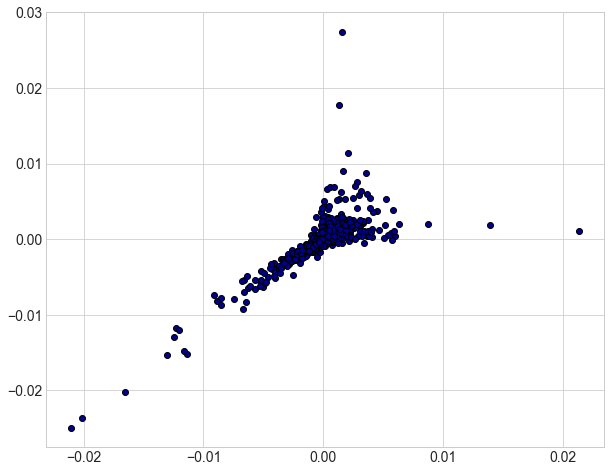

In [274]:
plt.scatter(SimSP, SimDJ, facecolor='darkblue', edgecolors='black')

In [24]:
from PyCopula import *

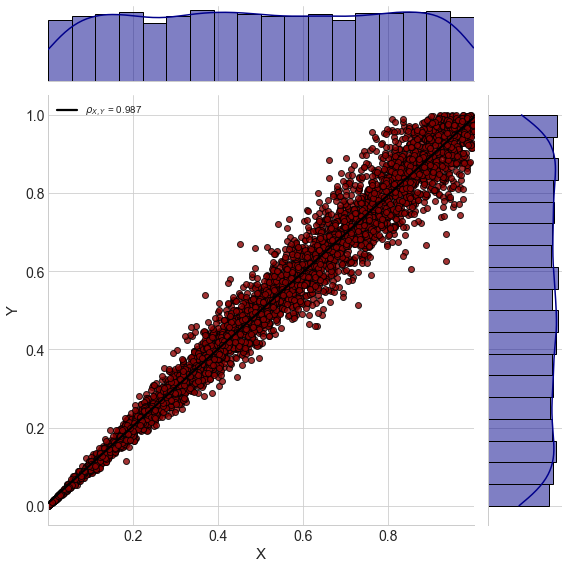

In [50]:
plotJoint(Sim, 'X', 'Y')

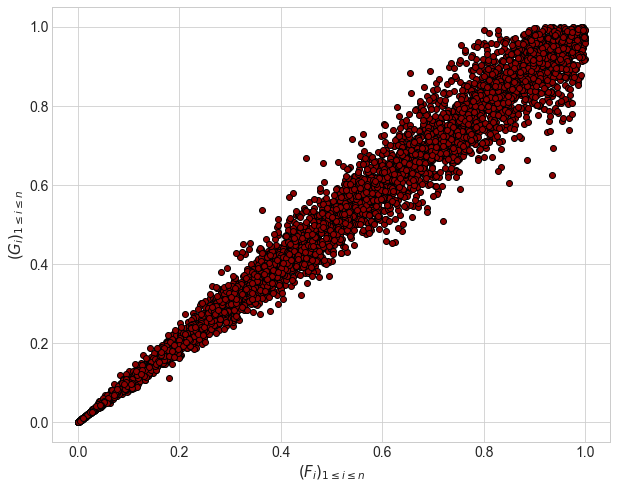

In [51]:
RankRankPlot(Sim['X'], Sim['Y'])

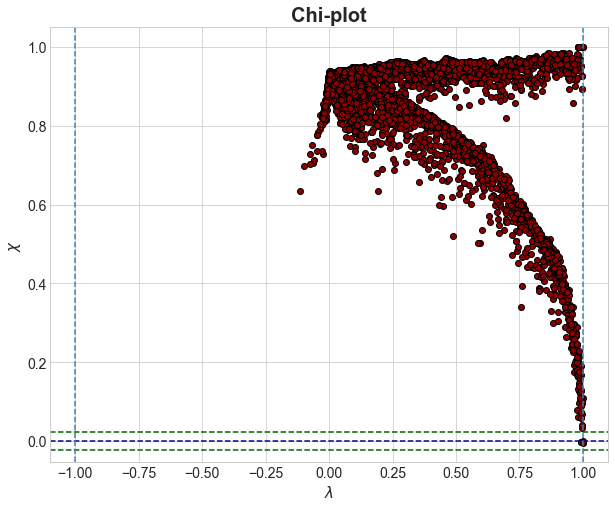

In [52]:
ChiPlot(Sim['X'], Sim['Y'])